In [ ]:
# Import key libraries
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import torch.random
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.io import read_image


from PIL import Image

import shutil
import subprocess
from pathlib import Path
import os
import sys
from google.colab import drive
import requests
import zipfile
from timeit import default_timer as timer
import time
import random

from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional, Union

import numpy as np

import matplotlib.pyplot as plt

import importlib

try:
  from torchinfo import summary
except:
  subprocess.run(["pip", "install", "torchinfo"],check=True)
  from torchinfo import summary

helper_function_path = "/content/Helper Functions"
if os.path.exists(helper_function_path):
  shutil.rmtree(helper_function_path)

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Helper%20Functions/copy_helper_functions.py"
code = requests.get(URL, timeout=30).text
exec(compile(code, URL, "exec"), {"__name__": "__main__"})

if os.path.exists("/content/Helper Functions"):
  for dirpath, dirnames, filenames in os.walk("/content/Helper Functions", topdown=True):
    sys.path.append(dirpath)
else:
  print("\u274c Error in loading Helper functions ")

import data_setup, engine, model_builder, utils, predict, icons

from helpers import download_data, set_seeds, plot_loss_curves

from icons import SUCCESS, ERROR, WARNING, INFO

device = "cuda" if torch.cuda.is_available() else "cpu"



Copying folder to working directory ...
Cleaning up cloned repository ...
✅ Copy complete!
[INFO] Predicting on None


In [ ]:
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_properties = torch.cuda.get_device_properties(0)
    total_memory = round(gpu_properties.total_memory / (1024**3), 2)
    cuda_capability = torch.cuda.get_device_capability(0)

    print(f"GPU Name: {gpu_name}")
    print(f"Total GPU Memory: {total_memory} GB")
    print(f"CUDA Capability: {cuda_capability[0]}.{cuda_capability[1]}")
else:
    print("No GPU available.")

GPU Name: NVIDIA A100-SXM4-80GB
Total GPU Memory: 79.32 GB
CUDA Capability: 8.0


# Learn from ResNet50 model to run on CIFAR10 dataset

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

def create_model(num_classes:int=10)->Tuple[nn.Module, T.Compose]:

  model_weights = ResNet50_Weights.DEFAULT
  transforms = model_weights.transforms()
  model = resnet50(weights=model_weights)

  #Adjust the fc layer to suit number of classes of CIFAR10. Resnet50 is trained on ImageNet model with 1000 classes
  model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)

  return model, transforms

In [ ]:
model, transforms = create_model()
transforms

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
summary(model,
        input_size=(1,3,32,32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        device="cpu")

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [1, 3, 32, 32]       [1, 10]              --                   True
├─Conv2d: 1-1                            [1, 3, 32, 32]       [1, 64, 16, 16]      9,408                True
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]      [1, 64, 16, 16]      128                  True
├─ReLU: 1-3                              [1, 64, 16, 16]      [1, 64, 16, 16]      --                   --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]      [1, 64, 8, 8]        --                   --
├─Sequential: 1-5                        [1, 64, 8, 8]        [1, 256, 8, 8]       --                   True
│    └─Bottleneck: 2-1                   [1, 64, 8, 8]        [1, 256, 8, 8]       --                   True
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]        [1, 64, 8, 8]        4,096                True
│    │    └─BatchN

In [ ]:
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Changing the Batch Size and Image Size based on available cuda memory

In [ ]:
# Check the GPU memeory available and total
gpu_mem_available, total_gpu_mem = torch.cuda.mem_get_info()
print(f"Available {round(gpu_mem_available/10**9, 3)} GB/{round(total_gpu_mem/10**9, 3)} GB")

gpu_mem_available = gpu_mem_available/10**9
if gpu_mem_available > 16:
  BATCH_SIZE = 128
  IMAGE_SIZE = 224
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128

print(f"GPU Memory available is {round(gpu_mem_available,3)} GB; using batch size of {BATCH_SIZE} and image size of {IMAGE_SIZE}")

# Get the default transforms object to extract mean and std
default_transforms = ResNet50_Weights.DEFAULT.transforms()

transforms = T.Compose([
    T.CenterCrop((IMAGE_SIZE,IMAGE_SIZE)),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=default_transforms.mean, std=default_transforms.std)
])


transforms

Available 84.723 GB/85.167 GB
GPU Memory available is 84.723 GB; using batch size of 128 and image size of 224


Compose(
    CenterCrop(size=(224, 224))
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Enable TensorFloat32 if available on GPU

In [ ]:
if cuda_capability >= (8,0):
  torch.backends.cuda.matmul.allow_tf32 = True
  torch.backends.cudnn.allow_tf32 = True
  print(f"GPU Score is: {cuda_capability} using TensorFloat32")
else:
  torch.backends.cuda.matmul.allow_tf32 = False
  torch.backends.cudnn.allow_tf32 = False
  print(f"GPU Score is: {cuda_capability} using Float32")

GPU Score is: (8, 0) using TensorFloat32


# Download CIFAR10 Dataset

In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="data",
                     train=True,
                     download=True,
                     transform=transforms)

test_dataset = CIFAR10(root="data",
                    train=False,
                    download=True,
                    transform=transforms)

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


# Create DataLoaders

In [ ]:
from numpy.matrixlib import test
import random
import numpy as np

# Define a worker initialization function to set seeds for each worker
def worker_init_fn(worker_id):
    # Use a unique seed for each worker to ensure reproducibility and proper device setup
    worker_seed = torch.initial_seed() % 2**32 + worker_id
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(worker_seed)

NUM_WORKERS = os.cpu_count()
print(f"Number of workers: {NUM_WORKERS}")

# Create explicit generators for CUDA device
train_g = torch.Generator()
test_g = torch.Generator()

train_g.manual_seed(42)
test_g.manual_seed(42)

train_dataloader = DataLoader(dataset=train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               num_workers=NUM_WORKERS,
                               pin_memory=True,
                               worker_init_fn=worker_init_fn,
                               generator=train_g) # Pass the CUDA generator

test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               num_workers=NUM_WORKERS,
                               pin_memory=True,
                               worker_init_fn=worker_init_fn,
                               generator=test_g) # Pass the CUDA generator

Number of workers: 12


# Train the model

In [ ]:
import importlib, engine
importlib.reload(engine)

<module 'engine' from '/content/Helper Functions/Important_PyTorch_ Modules/engine.py'>

# Train the model without `torch.compile()`

In [ ]:
from engine import train

model, _ = create_model()

model.to(device)

LEARNING_RATE = 0.001
EPOCHS = 5

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

start_training_time = timer()

results_without_compile = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

end_training_time = timer()

print(f"Training time without torch.compile(): {end_training_time - start_training_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8411 | train_acc: 70.9807 | train_time: 53.24 seconds | test_loss: 0.6432 | test_acc: 78.2931 | test_time: 4.76 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.5164 | train_acc: 82.3605 | train_time: 53.42 seconds | test_loss: 0.5815 | test_acc: 79.6776 | test_time: 4.63 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4030 | train_acc: 86.1881 | train_time: 53.41 seconds | test_loss: 0.5652 | test_acc: 81.3192 | test_time: 4.62 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3175 | train_acc: 89.0050 | train_time: 53.32 seconds | test_loss: 0.8257 | test_acc: 75.5142 | test_time: 4.64 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2514 | train_acc: 91.3903 | train_time: 53.28 seconds | test_loss: 1.1128 | test_acc: 71.4399 | test_time: 4.63 seconds
Training time without torch.compile(): 289.98 seconds


# Train the model using ` torch.compile() `

In [ ]:
from engine import train
from time import time

model, _ = create_model()

model.to(device)

LEARNING_RATE = 0.001
EPOCHS = 5

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Compile the model

compile_start = time()

compiled_model = torch.compile(model)

compile_time = time() - compile_start

print(f"Model compiled in {compile_time:.2f} seconds")

compiled_model.to(device)

start_training_time = time()

results_with_compile = train(
    model=compiled_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
    disable_progress_bar=False
)

end_training_time = time()

print(f"Training time with torch.compile(): {end_training_time - start_training_time:.2f} seconds")

Model compiled in 3.73 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8367 | train_acc: 70.8316 | train_time: 132.16 seconds | test_loss: 0.7828 | test_acc: 72.6661 | test_time: 16.89 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.5139 | train_acc: 82.4053 | train_time: 44.31 seconds | test_loss: 0.6026 | test_acc: 79.7172 | test_time: 3.87 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3892 | train_acc: 86.5409 | train_time: 44.23 seconds | test_loss: 0.5346 | test_acc: 81.6456 | test_time: 3.95 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3068 | train_acc: 89.5504 | train_time: 44.47 seconds | test_loss: 0.6350 | test_acc: 79.4304 | test_time: 4.02 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2512 | train_acc: 91.2284 | train_time: 44.30 seconds | test_loss: 0.7281 | test_acc: 79.4403 | test_time: 3.98 seconds
Training time with torch.compile(): 342.22 seconds


# Load the results in Pandas DataFrame to compare

In [ ]:
import pandas as pd
results_without_compile_df = pd.DataFrame(results_without_compile)
results_with_compile_df = pd.DataFrame(results_with_compile)

In [ ]:
results_consolidated_df = pd.concat([results_without_compile_df, results_with_compile_df], axis=0)
results_consolidated_df

,train_loss,train_acc,train_time,test_loss,test_acc,test_time
0,0.841107,70.980659,53.240809,0.643236,78.293117,4.761653
1,0.516417,82.360534,53.423946,0.581530,79.677611,4.629551
2,0.403023,86.188059,53.411001,0.565159,81.319225,4.620227
3,0.317542,89.004955,53.317964,0.825678,75.514241,4.635840
4,0.251383,91.390265,53.275806,1.112825,71.439873,4.627851
0,0.836690,70.831602,132.161230,0.782807,72.666139,16.891463
1,0.513879,82.405291,44.307572,0.602625,79.717168,3.873080
2,0.389207,86.540921,44.229933,0.534616,81.645570,3.951616
3,0.306839,89.550432,44.474478,0.635044,79.430380,4.019058
4,0.251166,91.228421,44.296462,0.728123,79.440269,3.984395


# Load the results in a .csv file

In [ ]:
import os
save_path = "/content/results"
if not os.path.exists(save_path):
  os.makedirs(save_path, exist_ok=True)
pd.DataFrame(results_consolidated_df).to_csv(f"{save_path}/single_run_results.csv")

# Calculate the averages of the results for each of the dataframes

In [ ]:
average_results_df = pd.concat([results_consolidated_df[:4].mean(axis=0), results_consolidated_df[4:].mean(axis=0)], axis=1)
average_results_df.columns = ["Without Compile", "With Compile"]
average_results_df

,Without Compile,With Compile
train_loss,0.519522,0.424861
train_acc,82.133552,85.324488
train_time,53.348430,60.457580
test_loss,0.653901,0.732673
test_acc,78.701048,77.389900
test_time,4.661818,6.224577


In [ ]:
average_results_df = average_results_df.transpose()

In [ ]:
average_results_df

,train_loss,train_acc,train_time,test_loss,test_acc,test_time
Without Compile,0.519522,82.133552,53.34843,0.653901,78.701048,4.661818
With Compile,0.424861,85.324488,60.45758,0.732673,77.389900,6.224577


# Plot the results (bar plot) to compare

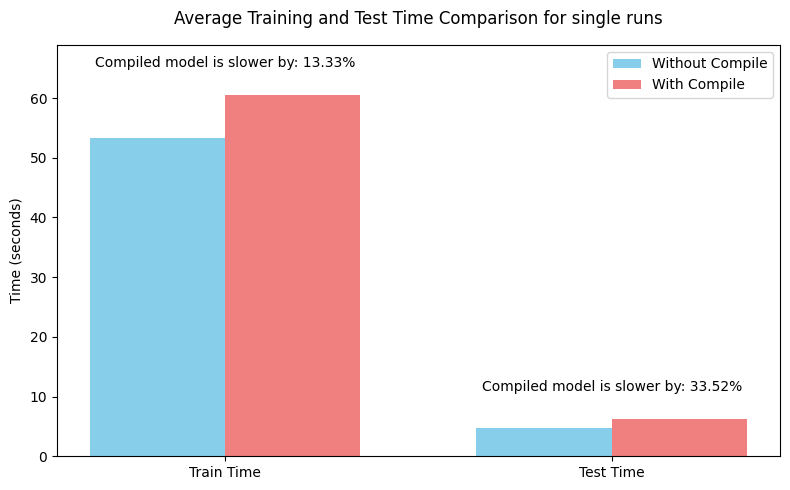

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the times for plotting by correcting the .loc indexing
train_time_without_compile = average_results_df.loc['Without Compile', 'train_time']
train_time_with_compile = average_results_df.loc['With Compile', 'train_time']
test_time_without_compile = average_results_df.loc['Without Compile', 'test_time']
test_time_with_compile = average_results_df.loc['With Compile', 'test_time']

# Calculate differences (relative change)
train_time_diff = (train_time_with_compile - train_time_without_compile) / train_time_without_compile
test_time_diff = (test_time_with_compile - test_time_without_compile) / test_time_without_compile

# Data for plotting
x_labels = ['Train Time', 'Test Time']
without_compile_values = [train_time_without_compile, test_time_without_compile]
with_compile_values = [train_time_with_compile, test_time_with_compile]

x = np.arange(len(x_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for 'Without Compile'
rects1 = ax.bar(x - width/2, without_compile_values, width, label='Without Compile', color='skyblue')

# Plot bars for 'With Compile'
rects2 = ax.bar(x + width/2, with_compile_values, width, label='With Compile', color='lightcoral')

# Labels, title, ticks
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Training and Test Time Comparison for single runs', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# --- Make space above bars for the % labels ---
y_max = max(without_compile_values + with_compile_values)
y_offset = y_max * 0.07          # vertical gap between bar top and text
ax.set_ylim(0, y_max + 2*y_offset)

# --- Add % difference labels above the bars ---
diffs = [train_time_diff, test_time_diff]

for i, diff in enumerate(diffs):
    percent = diff * 100
    annot = "Compiled model is slower by: " if percent >= 0 else "Compiled model is faster by: "

    ax.text(
        x[i],
        max(without_compile_values[i], with_compile_values[i]) + y_offset,
        f"{annot}{abs(percent):.2f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        # fontweight='bold'
    )

fig.tight_layout()
plt.show()

# Run each of the models (with and without compile) 3 times and average out the results

In [ ]:
from engine import train

model, _ = create_model()

model.to(device)

LEARNING_RATE = 0.001
EPOCHS = 5

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

start_training_time = timer()

run_results_without_compile = []

# Initialize tqdm with a generic description
pbar = tqdm(range(3), desc="Running iteration", disable=False)

for i in pbar:
  # Update the description dynamically inside the loop
  pbar.set_description_str(f"Running iteration {i+1}")
  start_run_time = timer()
  results_without_compile = train(
      model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=EPOCHS,
      device=device,
      disable_progress_bar=False
  )

  run_results_without_compile.append(results_without_compile)

  end_run_time = timer()

  print(f"Training time without torch.compile() for iteration {i+1}: {end_run_time - start_run_time:.2f} seconds")

end_training_time = timer()
print(f"Training time without torch.compile(): {end_training_time - start_training_time:.2f} seconds")

Running iteration:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8461 | train_acc: 70.6574 | train_time: 54.00 seconds | test_loss: 0.7651 | test_acc: 73.2298 | test_time: 4.96 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.5171 | train_acc: 82.3198 | train_time: 53.96 seconds | test_loss: 0.6115 | test_acc: 79.1436 | test_time: 4.94 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3930 | train_acc: 86.5421 | train_time: 53.84 seconds | test_loss: 0.5545 | test_acc: 81.2203 | test_time: 4.92 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3100 | train_acc: 89.3590 | train_time: 53.54 seconds | test_loss: 0.6991 | test_acc: 78.1942 | test_time: 4.96 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2539 | train_acc: 91.2272 | train_time: 53.78 seconds | test_loss: 0.5626 | test_acc: 82.6543 | test_time: 5.00 seconds
Training time without torch.compile() for iteration 1: 293.93 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1990 | train_acc: 93.1358 | train_time: 53.71 seconds | test_loss: 0.6399 | test_acc: 81.5961 | test_time: 4.94 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1617 | train_acc: 94.4094 | train_time: 53.74 seconds | test_loss: 0.9315 | test_acc: 77.5020 | test_time: 4.88 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1406 | train_acc: 95.2342 | train_time: 53.88 seconds | test_loss: 0.8449 | test_acc: 76.7603 | test_time: 4.95 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1161 | train_acc: 95.9447 | train_time: 53.85 seconds | test_loss: 0.6897 | test_acc: 82.2389 | test_time: 5.00 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0984 | train_acc: 96.5905 | train_time: 53.78 seconds | test_loss: 0.7607 | test_acc: 80.9434 | test_time: 4.90 seconds
Training time without torch.compile() for iteration 2: 293.65 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0911 | train_acc: 96.8642 | train_time: 53.76 seconds | test_loss: 11.3791 | test_acc: 21.9047 | test_time: 4.89 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.0747 | train_acc: 97.4512 | train_time: 53.76 seconds | test_loss: 0.8513 | test_acc: 81.0324 | test_time: 5.00 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.0726 | train_acc: 97.4684 | train_time: 53.72 seconds | test_loss: 0.7129 | test_acc: 83.2081 | test_time: 4.89 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.0714 | train_acc: 97.6299 | train_time: 53.78 seconds | test_loss: 31.7918 | test_acc: 9.9585 | test_time: 4.88 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0623 | train_acc: 97.8541 | train_time: 53.74 seconds | test_loss: 1.7551 | test_acc: 71.6080 | test_time: 5.05 seconds
Training time without torch.compile() for iteration 3: 293.49 seconds
Training time without torch.compile(): 881.08 seconds


In [ ]:
import pandas as pd

# Create an empty list to store DataFrames from each run
all_run_dfs = []

for run_result_dict in run_results_without_compile:
  # Convert each run's result dictionary into a DataFrame
  run_df = pd.DataFrame(run_result_dict)
  all_run_dfs.append(run_df)

# Concatenate all DataFrames from the list into a single DataFrame
run_results_all_without_compile_df = pd.concat(all_run_dfs, axis=0, ignore_index=True)

# Calculate the mean across all columns to get a Series
avg_series = run_results_all_without_compile_df.mean(axis=0)

# Convert the Series to a DataFrame with one row and transpose it
# The .to_frame().T makes it a DataFrame with 1 row and columns as the Series index
run_results_all_without_compile_df = avg_series.to_frame().T.rename(index={0: "Without Compile"})

# Display the aggregated DataFrame
display(run_results_all_without_compile_df)

,train_loss,train_acc,train_time,test_loss,test_acc,test_time
Without Compile,0.227206,92.179188,53.788293,3.569983,70.746308,4.943657


In [ ]:
from engine import train

model, _ = create_model()
model.to(device)
model = torch.compile(model)


LEARNING_RATE = 0.001
EPOCHS = 5

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

start_training_time = timer()

run_results_with_compile = []

# Initialize tqdm with a generic description
pbar = tqdm(range(3), desc="Running iteration", disable=False)

for i in pbar:
  # Update the description dynamically inside the loop
  pbar.set_description_str(f"Running iteration {i+1}")
  start_run_time = timer()
  results_with_compile = train(
      model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=EPOCHS,
      device=device,
      disable_progress_bar=False
  )

  run_results_with_compile.append(results_with_compile)

  end_run_time = timer()

  print(f"Training time with torch.compile() for iteration {i+1}: {end_run_time - start_run_time:.2f} seconds")

end_training_time = timer()
print(f"Training time with torch.compile(): {end_training_time - start_training_time:.2f} seconds")

Running iteration:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8648 | train_acc: 69.8517 | train_time: 44.56 seconds | test_loss: 0.9418 | test_acc: 70.5993 | test_time: 4.25 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.5204 | train_acc: 82.1240 | train_time: 44.36 seconds | test_loss: 0.6123 | test_acc: 79.0051 | test_time: 4.14 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3969 | train_acc: 86.3343 | train_time: 44.44 seconds | test_loss: 0.6122 | test_acc: 79.2128 | test_time: 4.16 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3145 | train_acc: 89.1872 | train_time: 44.58 seconds | test_loss: 0.6530 | test_acc: 79.8556 | test_time: 4.03 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2539 | train_acc: 91.3259 | train_time: 44.61 seconds | test_loss: 3.1693 | test_acc: 46.1036 | test_time: 4.09 seconds
Training time with torch.compile() for iteration 1: 243.27 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2007 | train_acc: 93.0511 | train_time: 44.32 seconds | test_loss: 0.6138 | test_acc: 81.9521 | test_time: 4.06 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1624 | train_acc: 94.3690 | train_time: 44.42 seconds | test_loss: 1.1301 | test_acc: 73.8331 | test_time: 4.13 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1370 | train_acc: 95.2206 | train_time: 44.58 seconds | test_loss: 0.6931 | test_acc: 81.0522 | test_time: 4.16 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1144 | train_acc: 96.0138 | train_time: 44.44 seconds | test_loss: 0.6234 | test_acc: 83.2377 | test_time: 4.23 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1017 | train_acc: 96.4934 | train_time: 44.76 seconds | test_loss: 0.6059 | test_acc: 83.6036 | test_time: 4.07 seconds
Training time with torch.compile() for iteration 2: 243.21 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0932 | train_acc: 96.8394 | train_time: 44.57 seconds | test_loss: 0.5952 | test_acc: 84.1377 | test_time: 4.17 seconds


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.0794 | train_acc: 97.2954 | train_time: 44.54 seconds | test_loss: 27.4631 | test_acc: 10.4233 | test_time: 4.06 seconds


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.0744 | train_acc: 97.3545 | train_time: 44.42 seconds | test_loss: 1.3760 | test_acc: 74.3968 | test_time: 4.16 seconds


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.0674 | train_acc: 97.6590 | train_time: 44.50 seconds | test_loss: 0.7773 | test_acc: 81.9422 | test_time: 4.07 seconds


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0632 | train_acc: 97.8617 | train_time: 44.48 seconds | test_loss: 0.6490 | test_acc: 84.5431 | test_time: 4.11 seconds
Training time with torch.compile() for iteration 3: 243.12 seconds
Training time with torch.compile(): 729.61 seconds


In [ ]:
import pandas as pd

# Create an empty list to store DataFrames from each run
all_run_dfs = []

for run_result_dict in run_results_with_compile:
  # Convert each run's result dictionary into a DataFrame
  run_df = pd.DataFrame(run_result_dict)
  all_run_dfs.append(run_df)

# Concatenate all DataFrames from the list into a single DataFrame
run_results_all_with_compile_df = pd.concat(all_run_dfs, axis=0, ignore_index=True)

# Calculate the mean across all columns to get a Series
avg_series = run_results_all_with_compile_df.mean(axis=0)

# Convert the Series to a DataFrame with one row and transpose it
# The .to_frame().T makes it a DataFrame with 1 row and columns as the Series index
run_results_all_with_compile_df = avg_series.to_frame().T.rename(index={0: "With Compile"})

# Display the aggregated DataFrame
display(run_results_all_with_compile_df)

,train_loss,train_acc,train_time,test_loss,test_acc,test_time
With Compile,0.229618,92.065404,44.506779,2.701036,72.926556,4.126487


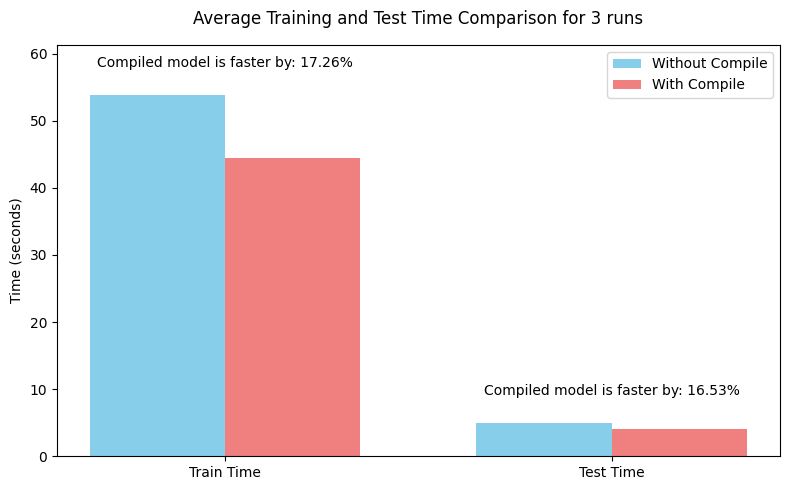

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the times for plotting
train_time_without_compile = run_results_all_without_compile_df.loc['Without Compile', 'train_time']
train_time_with_compile = run_results_all_with_compile_df.loc['With Compile', 'train_time']

test_time_without_compile = run_results_all_without_compile_df.loc['Without Compile', 'test_time']
test_time_with_compile = run_results_all_with_compile_df.loc['With Compile', 'test_time']

# Calculate differences (relative change)
train_time_diff = (train_time_with_compile - train_time_without_compile) / train_time_without_compile
test_time_diff = (test_time_with_compile - test_time_without_compile) / test_time_without_compile

# Data for plotting
x_labels = ['Train Time', 'Test Time']
without_compile_values = [train_time_without_compile, test_time_without_compile]
with_compile_values = [train_time_with_compile, test_time_with_compile]

x = np.arange(len(x_labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 5))

# Plot "Without Compile"
rects1 = ax.bar(
    x - width / 2,
    without_compile_values,
    width,
    label='Without Compile',
    color='skyblue'
)

# Plot "With Compile"
rects2 = ax.bar(
    x + width / 2,
    with_compile_values,
    width,
    label='With Compile',
    color='lightcoral'
)

# Labels, title, ticks
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Training and Test Time Comparison for 3 runs', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# --- Make space above bars for the % labels ---
y_max = max(without_compile_values + with_compile_values)
y_offset = y_max * 0.07          # vertical gap between bar top and text
ax.set_ylim(0, y_max + 2*y_offset)

# --- Add % difference labels above the bars ---
diffs = [train_time_diff, test_time_diff]

for i, diff in enumerate(diffs):
    percent = diff * 100
    annot = "Compiled model is slower by: " if percent >= 0 else "Compiled model is faster by: "

    ax.text(
        x[i],
        max(without_compile_values[i], with_compile_values[i]) + y_offset,
        f"{annot}{abs(percent):.2f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        # fontweight='bold'
    )

fig.tight_layout()
plt.show()
